# Equilibrium Molecule Classifier

## Purpose:
This model aims classify a set of relative atomic coordinates as being in equilibrium or nonequilibrium.

## Data Process
The dataset is created using the `qm9_create_tfdataset` Jupyter Notebook.

---


### Imports

All imports are grouped here for clarity

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Dropout
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

### Datasets

To evaluate model performance, we have created two seperate datasets. We have taken the same set of original molecules and displaced them by different amounts for a more comprehensive view of the models capabilties.

1. The primary dataset has a total displacement of 0.3 angrstroms across the atoms coordinates.
2. The secondary dataset has a total displacement of 0.5 angstroms across the atoms coordinates.

In [69]:
# --- GOOGLE DRIVE --- #
# If you are running this in Google Colab, using your Google Drive for the dataset, run this cell.
from google.colab import drive

drive.mount('/content/drive')

# Then in the next cell, set the path to your directories in Google Drive.
# e.g.
qm9_03_train = '/content/drive/MyDrive/qm9_03_train'
qm9_03_test = '/content/drive/MyDrive/qm9_03_test'

qm9_05_train = '/content/drive/MyDrive/qm9_05_train'
qm9_05_test = '/content/drive/MyDrive/qm9_05_test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- LOCAL FILES --- #

# Displaced by 0.3 angrstroms
qm9_03_train = "/Users/lyamtalbot/Library/CloudStorage/OneDrive-UniversityofNewEngland/cosc320-project-group-b/qm9_tensorflow_datasets/qm9_03/qm9_03_train"
qm9_03_test = "/Users/lyamtalbot/Library/CloudStorage/OneDrive-UniversityofNewEngland/cosc320-project-group-b/qm9_tensorflow_datasets/qm9_03/qm9_03_test"

# Displaced by 0.5 angrstroms
qm9_05_train = "/Users/lyamtalbot/Library/CloudStorage/OneDrive-UniversityofNewEngland/cosc320-project-group-b/qm9_tensorflow_datasets/qm9_05/qm9_05_train"
qm9_05_test = "/Users/lyamtalbot/Library/CloudStorage/OneDrive-UniversityofNewEngland/cosc320-project-group-b/qm9_tensorflow_datasets/qm9_05/qm9_05_test"

### Batch Size

We can keep the batch size high because of the light weight data
Must be a multiple of 8

In [70]:
batch_size = 32

### Masked Average Pooling

This method perform **Average Pooling** while considering the masking we have applied to padded all molecules to the same size.

Our **Masked Average Pooling** is ignoring the padded nodes and only averaging across the real nodes to create a single vector per graph.

In [71]:
def masked_avg_pooling(x, mask):
    mask = tf.expand_dims(mask, axis=-1) # batch_size, num_nodes, 1
    x_masked = x * mask # zero out masked nodes
    sum_x = tf.reduce_sum(x_masked, axis=1) # batch_size, feature_dim
    sum_mask = tf.reduce_sum(mask, axis=1) + 1e-7 # prevent division by zero
    return sum_x / sum_mask # batch_size, feature_dim

### Graph Convolutional Neural Network (GCNN) Layer Class

This custom layer is a based off example [MessagePassing layer by Spektral](https://graphneural.network/creating-layer/?utm_source=chatgpt.com)

Which itself is based off a GCN by [Kipf & and Welling, 2016](https://arxiv.org/abs/1609.02907)

For a more in-depth look at custom Keras layers please refer to the [TensorFlow Keras Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Layer?version=nightly)
and for the [Keras Layer API](https://keras.io/api/layers/).

It is essentially a standard dense layer but it allows message passing between neighbouring nodes.

#### \_\_init\_\_
This defines custom layer attributes, here we are defining our output size.

#### Build Method
This is called once to build the weights and bias based on the input shape.
Input shape here is

- Weights
The weights are initialised in the build method using the number inputs (neurons) to generate an equal number of weights.
The weights are what the model fine tunes as it learns.
- We initialise with `RandomUniform` providing a uniform distribution across the range (we are using the default range).

- Bias
The Bias is important to aid learning especially if the input is centered around zero.
- `zeros` for our initial bias which is a standard starting point.

#### Call Method
The `call` method is executed during each forward pass.
It performs message passing between a nodes neighbours which is essential for GNNs.

Then we apply the standard formula for a neural network dense layer:

(Formula description from UNE COSC351 lecture notes by Andreas Shepley)
`output = relu(dot(input, W) + b)`
- `input` represents the set of features (pixel values in an image).
- `W` represents a randomly initialised tensor of weights.
- `b` represents a randomly initialised vector of bias values.
- `relu` is the activation function that provides the layer's final output tensor.

We use the result of the message passing as input.
We apply the weight and bias to the message passing information.
We end by using `relu` (Rectified Linear Unit) as our activation function.
`relu` converts negative numbers to zero and introduces non-linearity for more complex features to be learned.

In [72]:
from keras.saving import register_keras_serializable

# Reference: @register_keras_serialiable() was a solution provided by
# generative AI for the issues loading the custom layer into the xyz_model.py script.
@register_keras_serializable()
class GCNNLayer(layers.Layer):
    # Constructor for the Graph Convolutional Neural Network Layer
    def __init__(self, output_size, **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        # Should be default values
        self.initializer = RandomUniform(minval=-0.05, maxval=0.05, seed=None)

    # Build creates the state of the layer (weights and bias)
    def build(self, input_shape):
        # num_features per node
        num_features = input_shape[0][-1]
        # This is our main weights matrix
        self.kernel = self.add_weight(shape=(num_features, self.output_size),initializer=self.initializer)
        # This is to add a bias to the output
        self.bias = self.add_weight(shape=(self.output_size,),initializer='zeros')
        # Build the layer by calling the parent class and this method
        super().build(input_shape)

    # Called every forward pass for the GraphConvLayer
    def call(self, inputs):
        # Extract the node features and adjacency matrix
        node_features, adjacency = inputs

        # Message passing via adjacency matrix
        # For each node, we multiply the adjacency matrix with the node features
        messages = tf.matmul(adjacency, node_features)

        # Apply the weights and bias then the activation function
        return relu(tf.matmul(messages, self.kernel) + self.bias)

### Graph Inputs

- max_nodes is set to 26 meaning no input molecule can have more the 26 atoms.
- feature_dim is set to 8 because each atom is one of five types in the QM9 dataset and it will have 3 coordinates associated with it (x, y, z)

`input_mols input_adj input_mask` are declaring the shape of the tensors for our model to know what to expect.

In [73]:
max_nodes = 26
feature_dim = 8

# Graph inputs
input_mols = Input(shape=(max_nodes, feature_dim), name="node_features_input")
input_adj = Input(shape=(max_nodes, max_nodes), name="adjacency_matrix_input")
input_mask = Input(shape=(max_nodes,), name="mask_input")

### Scalar Input

In [74]:
# Scalar input (global)
input_energy_gap = Input(shape=(1,), name="energy_gap_input")

### GCNN Layers

Two GCNN layers based on testing.

In [75]:
x = GCNNLayer(32)([input_mols, input_adj])
x = GCNNLayer(32)([x, input_adj])

### Graph Embedding



In [ ]:
graph_embedding = Lambda(
    lambda args: masked_avg_pooling(args[0], args[1]),
    output_shape=(32,), # make sure this matches your GCN output feature dim
    name="graph_pooling"
)([x, input_mask]) # x: (batch_size, N, 32), input_mask: (batch_size, N)

### Prepare Dropout and Output Layers

In [ ]:
# (Optional) Transform scalar input if needed
energy_dense = Dense(8, activation='relu', name="energy_transform")(input_energy_gap)

# Combine graph embedding and scalar input
combined = Concatenate(name="combined_features")([graph_embedding, energy_dense])

# Feed forward
dropout = Dropout(0.5)(combined)
output = Dense(1, activation='sigmoid')(dropout)

### Model Declaration


In [80]:
xyz_model = Model(inputs=[input_mols, input_adj, input_mask, input_energy_gap], outputs=output)

### Model Checkpoint

The model checkpoint is passed into the fit method as a callback, it is an automated process to save a snapshot of the model at a certain point of training.
Here we are saving the model when validation accuracy has improved.

In [81]:
checkpoint_cb = ModelCheckpoint(
filepath="xyz_model.keras", # File path to save the model
save_best_only=True, # Only save when the model is better
monitor='val_accuracy', # Metric to monitor
mode='max', # Mode: 'max' for accuracy
verbose=0 # Verbosity mode
)

### Early Stopping

Early stopping is passed into the fit method as a callback, it is an automated process to monitor the model as it trains.

Based on the arugments it will stop training when certain conditions are met.

In [82]:
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb = EarlyStopping(
monitor='val_accuracy', # Metric to monitor
patience=5, # Number of epochs with no improvement after which training will be stopped
restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored metric
mode='max', # Mode: 'max' for accuracy
verbose=1 # Verbosity mode
)

### Optimiser

The optimiser is how the learning actually happens, it is what updates the parameters of the model.

- **Adam** (Adaptive Moment Estimation) optimiser combines the best of two optimisers (AdaGrad and RMSProp).
- **RMSProp** (Root Mean Square Propagation) is your standard optimiser for most problems.
- **AdaGrad** (Adaptive Gradient) adapts the learning rate for each parameter.

In [83]:
optimizer = Adam(1e-3)

### Compiling the Model

**Arguments**
- Loss Function: `BinaryFocalCrossentropy`
- Metrics: `accuracy`

In [84]:
xyz_model.compile(optimizer=optimizer,
              loss = BinaryFocalCrossentropy(
              apply_class_balancing=False,
              alpha=0.25,
              gamma=2,
              from_logits=False,
              label_smoothing=0.0,
              axis=-1,
              reduction="sum_over_batch_size",
              name="binary_focal_crossentropy",
              dtype=None,
              ),
              metrics=['accuracy'],
                )
xyz_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ node_features_input │ (None, 26, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_matrix_i… │ (None, 26, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcnn_layer_2        │ (None, 26, 32)    │        288 │ node_features_in… │
│ (GCNNLayer)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcnn_layer_3        │ (None, 26, 32)    │      1,056 │ gcnn_layer_2[0][… │
│ (GCNNLayer)         │                   │            │ adjacency_matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ energy_gap_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_pooling       │ (None, 32)        │          0 │ gcnn_layer_3[0][… │
│ (Lambda)            │                   │            │ mask_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ energy_transform    │ (None, 8)         │         16 │ energy_gap_input… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_features   │ (None, 40)        │          0 │ graph_pooling[0]… │
│ (Concatenate)       │                   │            │ energy_transform… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40)        │          0 │ combined_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         41 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,401 (5.47 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

### Train/Val/Test Datasets

Splitting the data into three datasets.

- Train: This is the largest dataset and it is the dataset that the model uses to learn patterns and features and specifically to update its weights with the loss function.

- Val: The validation data is taken from the training data before training occurs, it is passed in alongside the training data for monitoring the training performance.

- Test: It is critical that during training the model does not see the test dataset. Here, the test dataset is kept in a seperate folder to ensure the model cannot learn the test data.

In [85]:
train_ds = tf.data.Dataset.load(qm9_03_train)
test_ds = tf.data.Dataset.load(qm9_03_test)
test_ds_05 = tf.data.Dataset.load(qm9_05_test)

for (molecule, adj, mask, energy_gap), label in train_ds.take(1):
    print("molecule shape:", molecule.shape)
    print("adj shape:", adj.shape)
    print("mask shape:", mask.shape)
    print("energy_gap shape:", energy_gap.shape)
    print("label shape:", label.shape)

full_train_ds = train_ds
total = train_ds.cardinality().numpy()
train_size = int(total * 0.8)

train_ds = train_ds.take(train_size)
val_ds = full_train_ds.skip(train_size)

train_ds = train_ds.batch(batch_size, drop_remainder=True)
val_ds = val_ds.batch(batch_size, drop_remainder=True)
test_ds = test_ds.batch(batch_size, drop_remainder=True)
test_ds_05 = test_ds_05.batch(batch_size, drop_remainder=True)

molecule shape: (26, 8)
adj shape: (26, 26)
mask shape: (26,)
energy_gap shape: (1,)
label shape: (1,)


### Training the Model

The training method `fit()` returns a history object that we can use to observe performance.

In [86]:
history = xyz_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5037 - loss: 0.1768 - val_accuracy: 0.5322 - val_loss: 0.1724
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5209 - loss: 0.1731 - val_accuracy: 0.5847 - val_loss: 0.1692
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5764 - loss: 0.1698 - val_accuracy: 0.6306 - val_loss: 0.1636
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6258 - loss: 0.1630 - val_accuracy: 0.7459 - val_loss: 0.1477
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7272 - loss: 0.1452 - val_accuracy: 0.8087 - val_loss: 0.1265
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7863 - loss: 0.1264 - val_accuracy: 0.8225 - val_loss: 0.1118
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8109 - loss: 0.1138 - val_accuracy: 0.8234 - val_loss: 0.1064
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8142 - loss: 0.1098 - val_accu

### Visualise the training performance


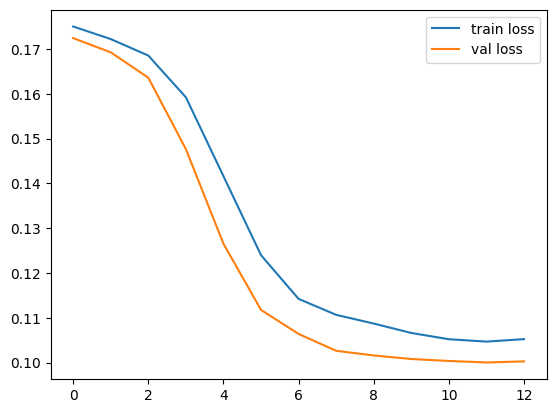

In [87]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()

### Making Predictions

Here we get the model to make predictions on the unseen test data.

In [ ]:
# Run predictions on our test dataset
preds = xyz_model.predict(test_ds).flatten()

# This is for storing our labels
true = []

# Extract and store each label
for _, y in test_ds.as_numpy_iterator():
    true.extend(y)
true = np.array(true).flatten()

# Count the number of correct vs incorrect predictions
correct = 0
incorrect = 0

# Iterate through the predictions, round the probability for a label
for i in range(10):
    rounded = int(np.round(preds[i]))
    actual = int(true[i])
    if rounded == actual:
        correct += 1
    else:
        incorrect += 1
    print(f"Sample Num: {i+1}, Real Label: {actual}, Predicted Label: {rounded}, Predicted Probability: {preds[i]:.4f}")

print(f"\nCorrectly classified: {correct}/{incorrect + correct}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sample Num: 1, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.5797
Sample Num: 2, Real Label: 0, Predicted Label: 1, Predicted Probability: 0.6199
Sample Num: 3, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.2712
Sample Num: 4, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.1720
Sample Num: 5, Real Label: 0, Predicted Label: 1, Predicted Probability: 0.5471
Sample Num: 6, Real Label: 0, Predicted Label: 1, Predicted Probability: 0.5890
Sample Num: 7, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.1037
Sample Num: 8, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.5824
Sample Num: 9, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.5758
Sample Num: 10, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.5945

Correctly classified:  7/10


In [ ]:
# Run predictions on our test dataset
preds_05 = xyz_model.predict(test_ds_05).flatten()

# This is for storing our labels
true_05 = []

# Extract and store each label
for _, y in test_ds_05.as_numpy_iterator():
    true_05.extend(y)
true_05 = np.array(true_05).flatten()

# Count the number of correct vs incorrect predictions
correct_05 = 0
incorrect_05 = 0

# Iterate through the predictions, round the probability for a label
for i in range(10):
    rounded_05 = int(np.round(preds_05[i]))
    if rounded_05 == true_05[i]:
        correct_05 += 1
    else:
        incorrect_05 += 1
    print(f"Sample Num: {i+1}, Real Label: {int(true_05[i])}, Predicted Label: {rounded_05}, Predicted Probability: {preds_05[i]:.4f}")

print(f"\nCorrectly classified: {correct_05}/{correct_05 + incorrect_05}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample Num: 1, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.6132
Sample Num: 2, Real Label: 0, Predicted Label: 1, Predicted Probability: 0.5743
Sample Num: 3, Real Label: 0, Predicted Label: 1, Predicted Probability: 0.5659
Sample Num: 4, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.5759
Sample Num: 5, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.1869
Sample Num: 6, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.6066
Sample Num: 7, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.0395
Sample Num: 8, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.2870
Sample Num: 9, Real Label: 0, Predicted Label: 0, Predicted Probability: 0.1809
Sample Num: 10, Real Label: 1, Predicted Label: 1, Predicted Probability: 0.5493

Correctly classified:  8/10


In [ ]:
print(f"\n\nClassification with 0.3 Angstrom displacement: {correct}/{correct + incorrect}")
print(f"\n\nClassification with 0.5 Angstrom displacement: {correct_05}/{correct_05 + incorrect_05}")



Classification with 0.3 Angstrom displacement:  7/10


Classification with 0.5 Angstrom displacement:  8/10


### Evaluating the Model

The evaluate method can be executed on either the test or val datasets to return some metrics on how the model performs.

In [ ]:
loss, accuracy = xyz_model.evaluate(test_ds_05)

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8200 - loss: 0.1006


In [ ]:
loss, accuracy = xyz_model.evaluate(test_ds)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.1028


### Save the model

In [ ]:
xyz_model.save("/content/drive/MyDrive/xyz_model.keras", include_optimizer=False)